# Example usage

Run this notebook locally or via free cloud platforms:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/wgms-org/mb-downscaling/main?labpath=demo.ipynb)

## Import packages

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mb_downscaling

## Represent mass balance with sine functions

The mass balance over a hydrological year (an annual winter-summer cycle) is represented by separate sine functions for the winter (accumulation) and summer (ablation) seasons.

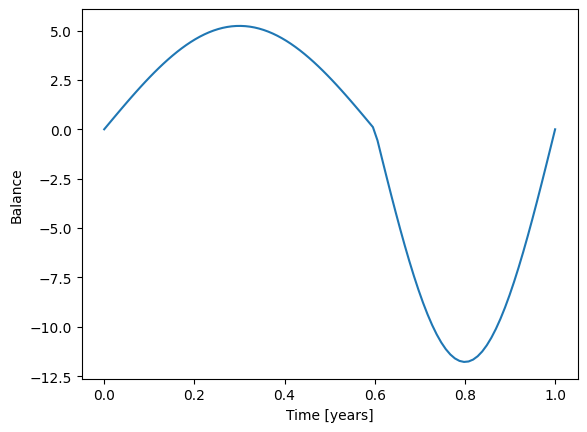

In [2]:
# Parameters
winter_balance = 2  # Total mass balance over winter
summer_balance = -3  # Total mass balance over summer
winter_fraction = 0.6  # Length of winter as fraction of year

# Define a sine function for each season
winter_sine = mb_downscaling.generate_seasonal_sine(
  balance=winter_balance, interval=(0, winter_fraction)
)
summer_sine = mb_downscaling.generate_seasonal_sine(
  balance=summer_balance, interval=(winter_fraction, 1)
)

# Calculate balance as the sum of the (masked) winter and summer sine functions
time = np.linspace(0, 1, 100)
balance = (
  mb_downscaling.evaluate_sine(time, **winter_sine, mask=(0, winter_fraction)) +
  mb_downscaling.evaluate_sine(time, **summer_sine, mask=(winter_fraction, 1))
)

# Plot the result
plt.plot(time, balance)
plt.ylabel('Balance')
plt.xlabel('Time [years]')
plt.show()

Generally, we are interested in the mass balance over an interval of time. This can be calculated by taking the definite integral of the sine functions above. As an example, we check that seasonal balances calculated by this method are equal to the seasonal balances defined above.

In [3]:
print(
  winter_balance,
  mb_downscaling.integrate_sine([(0, winter_fraction)], **winter_sine)
)
print(
  summer_balance,
  mb_downscaling.integrate_sine([(winter_fraction, 1)], **summer_sine)
)

2 [2.]
-3 [-3.]


## Create a test dataset

For the steps that follow, we will use a timeseries of seasonal (or in some years, just annual) mass balance measurements.

In [4]:
df = pd.DataFrame(
  data=[
    [2000, np.nan, np.nan, -500],
    [2001, np.nan, np.nan, -250],
    [2002, np.nan, np.nan, 0],
    [2003, np.nan, np.nan, 100],
    [2004, np.nan, np.nan, -1500],
    [2005, 1000, -1500, -500],
    [2006, 1000, -1250, -250],
    [2007, 750, -750, 0],
    [2008, 1500, -1400, 100],
    [2009, 1000, -2500, -1500]
  ],
  columns=['year', 'winter_balance', 'summer_balance', 'annual_balance']
)
df

,year,winter_balance,summer_balance,annual_balance
0,2000,NaN,NaN,-500
1,2001,NaN,NaN,-250
2,2002,NaN,NaN,0
3,2003,NaN,NaN,100
4,2004,NaN,NaN,-1500
5,2005,1000.0,-1500.0,-500
6,2006,1000.0,-1250.0,-250
7,2007,750.0,-750.0,0
8,2008,1500.0,-1400.0,100
9,2009,1000.0,-2500.0,-1500


## Fill missing seasonal balances

We can estimate the missing seasonal balances from the annual balance and an assumed mass-balance amplitude. One option for the latter is the mean of the mass-balance amplitudes calculated for each year with seasonal balances.

In [5]:
balance_amplitude = mb_downscaling.calculate_balance_amplitude(
  winter_balance=df['winter_balance'],
  summer_balance=df['summer_balance']
)
balance_amplitude.mean()

1265.0

This is the default strategy used by `fill_balances`.

In [6]:
wsa = ['winter_balance', 'summer_balance', 'annual_balance']
mb_downscaling.fill_balances(df[wsa])

array([[ 1015., -1515.,  -500.],
       [ 1140., -1390.,  -250.],
       [ 1265., -1265.,     0.],
       [ 1315., -1215.,   100.],
       [  515., -2015., -1500.],
       [ 1000., -1500.,  -500.],
       [ 1000., -1250.,  -250.],
       [  750.,  -750.,     0.],
       [ 1500., -1400.,   100.],
       [ 1000., -2500., -1500.]])

## Downscale seasonal balances

The function `downscale_balance_series` is a convenient wrapper around many of the other functions. Below, we use it to downscale our balances to daily resolution. Missing seasonal balances are filled using the method described above.

In [7]:
intervals, balances = mb_downscaling.downscale_balance_series(
  years=df['year'],
  balances=df[wsa],
  winter_start=(10, 1),
  winter_fraction=8/12,
  interval_width=datetime.timedelta(days=1)
)
daily = pd.DataFrame({
  'start': intervals[:, 0], 'end': intervals[:, 1], 'balance': balances
})
daily

,start,end,balance
0,1999-10-01,1999-10-02,0.042065
1,1999-10-02,1999-10-03,0.126188
2,1999-10-03,1999-10-04,0.210290
3,1999-10-04,1999-10-05,0.294357
4,1999-10-05,1999-10-06,0.378375
...,...,...,...
3648,2009-09-26,2009-09-27,-3.741875
3649,2009-09-27,2009-09-28,-2.912938
3650,2009-09-28,2009-09-29,-2.082058
3651,2009-09-29,2009-09-30,-1.249790


Calculate the total daily balance over the entire record. It should be equal to the total annual balance for the same period.

In [8]:
print(
  df['annual_balance'].sum(),
  daily['balance'].sum()
)

-4300 -4300.0


## Plot the results

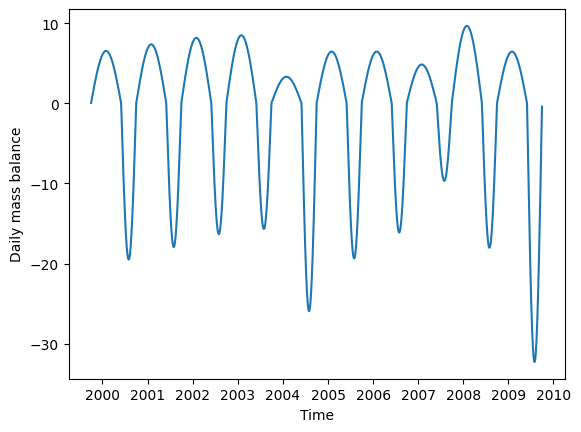

In [9]:
plt.plot(daily['start'], daily['balance'])
plt.ylabel('Daily mass balance')
plt.xlabel('Time')
plt.show()

_So long, and thanks for all the fish_ (Douglas Adams)